In [1]:
# fetch dataset
import pandas as pd

df = pd.read_csv("./cyberbullying_tweets.csv", encoding="latin1")
print(df.columns)
print(df.shape)


Index(['tweet_text', 'cyberbullying_type'], dtype='object')
(47692, 2)


In [2]:
print(df["cyberbullying_type"].value_counts())


religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64


In [3]:
# lemmatize messages
import spacy

text = []
neg_pol = []
pos_pol = []

nlp = spacy.load("en_core_web_sm", enable=["tagger", "attribute_ruler", "lemmatizer"])
for doc in nlp.pipe(df["tweet_text"]):
    text.append(" ".join([token.lemma_.lower() for token in doc 
                          if token.is_alpha and not token.is_stop]))

df["text_lemma"] = text


In [4]:
# sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sid_obj = SentimentIntensityAnalyzer()
df["neg"] = [sid_obj.polarity_scores(msg)["neg"] for msg in df["tweet_text"]]
df["neu"] = [sid_obj.polarity_scores(msg)["neu"] for msg in df["tweet_text"]]
df["pos"] = [sid_obj.polarity_scores(msg)["pos"] for msg in df["tweet_text"]]
df["compound"] = [sid_obj.polarity_scores(msg)["compound"] for msg in df["tweet_text"]]


In [5]:
# polarity scores for each class
print("age:", df.loc[df["cyberbullying_type"] == "age", "compound"].mean())
print("ethnicity", df.loc[df["cyberbullying_type"] == "ethnicity", "compound"].mean())
print("gender", df.loc[df["cyberbullying_type"] == "gender", "compound"].mean())
print("religion", df.loc[df["cyberbullying_type"] == "religion", "compound"].mean())
print("other_cyberbullying", df.loc[df["cyberbullying_type"] == "other_cyberbullying", "compound"].mean())
print("not_cyberbullying", df.loc[df["cyberbullying_type"] == "not_cyberbullying", "compound"].mean())


age: -0.35374030280280283
ethnicity -0.6236070342921742
gender -0.3010298883732597
religion -0.3021480995248812
other_cyberbullying -0.07116475776556308
not_cyberbullying -0.046767589679043424


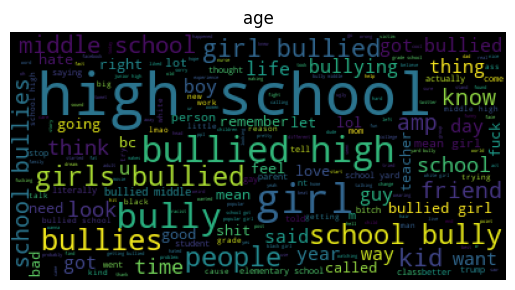

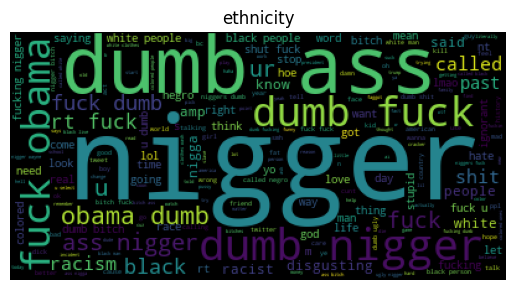

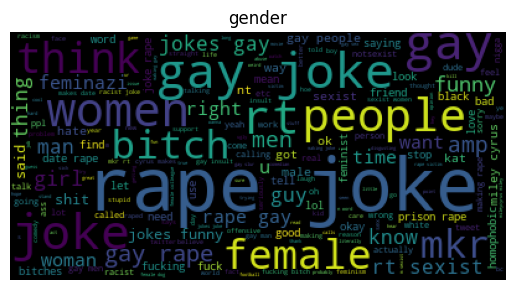

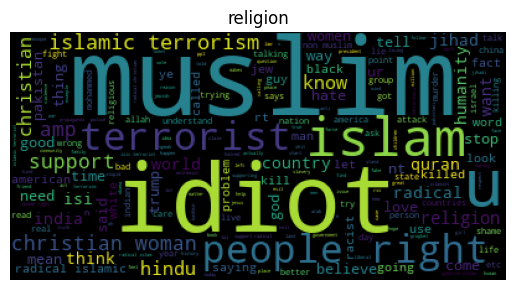

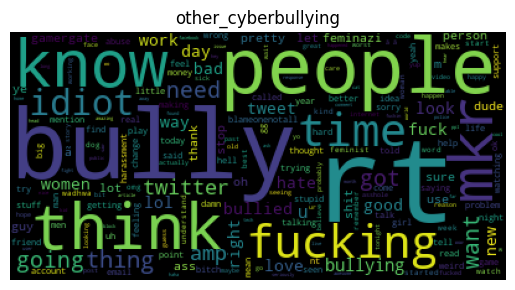

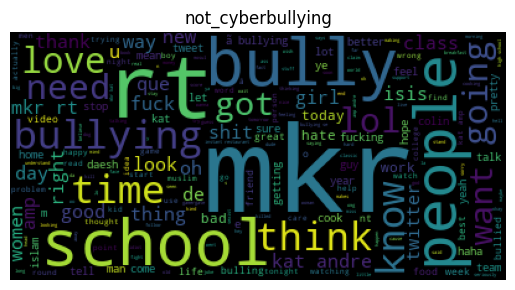

In [6]:
# generate word clouds
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud()

wc_age = wc.generate(" ".join(df.loc[df["cyberbullying_type"] == "age", "text_lemma"]))
plt.imshow(wc_age)
plt.title("age")
plt.axis("off")
plt.show()

wc_ethnicity = wc.generate(" ".join(df.loc[df["cyberbullying_type"] == "ethnicity", "text_lemma"]))
plt.imshow(wc_ethnicity)
plt.title("ethnicity")
plt.axis("off")
plt.show()

wc_gender = wc.generate(" ".join(df.loc[df["cyberbullying_type"] == "gender", "text_lemma"]))
plt.imshow(wc_gender)
plt.title("gender")
plt.axis("off")
plt.show()

wc_religion = wc.generate(" ".join(df.loc[df["cyberbullying_type"] == "religion", "text_lemma"]))
plt.imshow(wc_religion)
plt.title("religion")
plt.axis("off")
plt.show()

wc_other = wc.generate(" ".join(df.loc[df["cyberbullying_type"] == "other_cyberbullying", "text_lemma"]))
plt.imshow(wc_other)
plt.title("other_cyberbullying")
plt.axis("off")
plt.show()

wc_not = wc.generate(" ".join(df.loc[df["cyberbullying_type"] == "not_cyberbullying", "text_lemma"]))
plt.imshow(wc_not)
plt.title("not_cyberbullying")
plt.axis("off")
plt.show()


In [7]:
# convert to tf-idf representation
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(ngram_range=(1,2))
text_tfidf = vect.fit_transform(df["text_lemma"])


In [8]:
# add polarity scores to data
from scipy.sparse import hstack

polarity = df[["neg", "neu", "pos"]].to_numpy()

print(text_tfidf.shape)
print(polarity.shape)

data = hstack((text_tfidf, polarity))

print(data.shape)

(47692, 358598)
(47692, 3)
(47692, 358601)


In [9]:
# split data for test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, df["cyberbullying_type"], 
                                                    test_size=0.2, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(38153, 358601)
(38153,)
(9539, 358601)
(9539,)


In [10]:
# evaluate model
from sklearn import metrics

def report_metrics(y_test, y_pred):
    labels = ["age", "ethnicity", "gender", "religion", "other_cyberbullying", "not_cyberbullying"]
    print(metrics.classification_report(y_test, y_pred, labels=labels))
    
    metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=labels)
    plt.xticks(rotation=45)
    plt.show()


                     precision    recall  f1-score   support

                age       0.75      0.99      0.85      1603
          ethnicity       0.86      0.90      0.87      1603
             gender       0.79      0.84      0.81      1531
           religion       0.79      0.98      0.87      1566
other_cyberbullying       0.56      0.35      0.43      1612
  not_cyberbullying       0.57      0.41      0.48      1624

           accuracy                           0.74      9539
          macro avg       0.72      0.74      0.72      9539
       weighted avg       0.72      0.74      0.72      9539



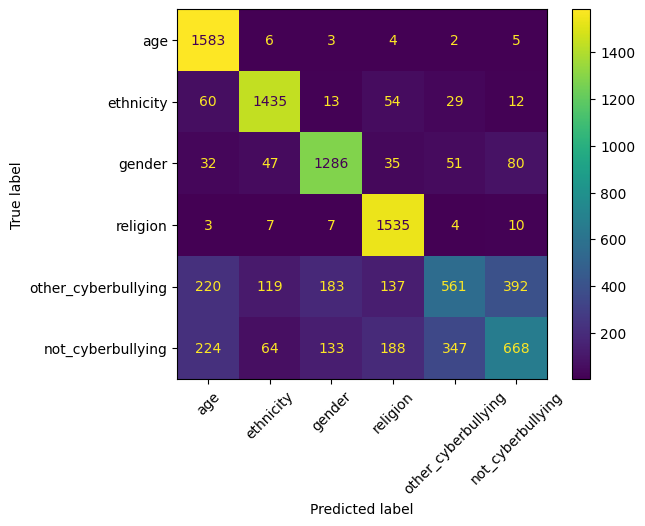

In [11]:
# multinomial naive bayes classification
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

mnb.fit(x_train, y_train)
y_pred = mnb.predict(x_test)

report_metrics(y_test, y_pred)
